In [1775]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression

In [1776]:
df = pd.read_excel('yandex_hack.xlsx')

# 1. Просмотрим данные

In [1777]:
df.head()

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city
0,2015-09-15 21:08:43.000000,B,7cc98331ddb8ccffe464455f3df763d9,NaN,0b6f25c79b35fd1e6d28d845b7ee511d,NaN,3f1b96f620988a92d3409ea05e87bd36,3,c6fbacc5cab7e134c9db2a4bbfcc5b64
1,2015-09-13 18:40:12.000000,A,9b73035bb90cd7de4b9c1ff01e44f178,NaN,793f2fa9aa3d52d2da05caa3c30cb77e,NaN,8ed37467dc9b257b3b3bdc1bfebd9b28,8,e6705560085199e9674cd721ee844d0d
2,2015-09-14 01:52:40.000000,A,9b73035bb90cd7de4b9c1ff01e44f178,NaN,b6c5ec927a3e314b0900c103a0cd68fa,NaN,5b17547f825d9cf35c7853621dd842f8,1,e6705560085199e9674cd721ee844d0d
3,2015-09-13 17:23:52.000000,B,7cc98331ddb8ccffe464455f3df763d9,NaN,5dc658f0928569dbefac74c9f311031c,NaN,81647a72700bd46635d9606082360cc8,6,c6fbacc5cab7e134c9db2a4bbfcc5b64
4,2015-09-13 11:15:05.000000,B,7cc98331ddb8ccffe464455f3df763d9,NaN,3da09410aeab781baf4b7039fc9b125c,NaN,065c18216b6d3369d4cc36418c6e80f2,7,c6fbacc5cab7e134c9db2a4bbfcc5b64


In [1778]:
# переведем время в формат datetime64 и выделим день и час заказа 

df['order_created_datetime'] = pd.to_datetime(df['order_created_datetime'], format="%Y-%m-%d %H:%M:%S")

df['day'] = df['order_created_datetime'].dt.day

df['hour'] = df['order_created_datetime'].dt.hour

In [1779]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66464 entries, 0 to 66463
Data columns (total 11 columns):
order_created_datetime     66464 non-null datetime64[ns]
brand_name                 66464 non-null object
rest_id                    66464 non-null object
batched_with_order_id      442 non-null object
order_id                   66464 non-null object
first_in_multiorder_flg    442 non-null float64
courier_id                 66202 non-null object
order_items_cnt            66464 non-null int64
city                       66464 non-null object
day                        66464 non-null int64
hour                       66464 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 5.6+ MB


Выводы
------

1. Есть пропуски в столбце courier_id. 
2. Есть пропуски в столбцах batched_with_order_id и first_in_multiorder_flg. Пропуски свидетельствует для группы рестаранов А то, что мультизаказов нет. Для группы рестаранов В необходимо дополнительно изучить.

In [1780]:
# выделим рестораны бренда А

dfA = df[df.brand_name == 'A']

In [1781]:
dfA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9629 entries, 1 to 66463
Data columns (total 11 columns):
order_created_datetime     9629 non-null datetime64[ns]
brand_name                 9629 non-null object
rest_id                    9629 non-null object
batched_with_order_id      442 non-null object
order_id                   9629 non-null object
first_in_multiorder_flg    442 non-null float64
courier_id                 9437 non-null object
order_items_cnt            9629 non-null int64
city                       9629 non-null object
day                        9629 non-null int64
hour                       9629 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 902.7+ KB


In [1782]:
dfA.describe()

,first_in_multiorder_flg,order_items_cnt,day,hour
count,442.000000,9629.00000,9629.000000,9629.000000
mean,0.500000,4.86333,14.002492,14.861460
std,0.500567,2.86872,0.933382,4.611396
min,0.000000,1.00000,13.000000,0.000000
25%,0.000000,3.00000,13.000000,12.000000
50%,0.500000,4.00000,14.000000,15.000000
75%,1.000000,6.00000,15.000000,18.000000
max,1.000000,35.00000,16.000000,23.000000


In [1783]:
dfA.describe(include=['O'])

,brand_name,rest_id,batched_with_order_id,order_id,courier_id,city
count,9629,9629,442,9629,9437,9629
unique,1,518,442,9629,4034,30
top,A,9b73035bb90cd7de4b9c1ff01e44f178,384c618983509d6993a9c38327ab3ff7,39391b06846d043265c0b41536b0dead,5b17547f825d9cf35c7853621dd842f8,e6705560085199e9674cd721ee844d0d
freq,9629,107,1,1,643,4878


# 2. Просмотрим города, в которых есть рестораны А

In [1784]:
cityA = dfA.city.value_counts()

In [1785]:
# просмотрим как распределяются мультизаказы ресторанов бренда А в разрезе городов

for city in cityA.index:
    
    print('City ', city)
    dfA[dfA.city == city].info()
    print()

City  e6705560085199e9674cd721ee844d0d
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4878 entries, 1 to 66463
Data columns (total 11 columns):
order_created_datetime     4878 non-null datetime64[ns]
brand_name                 4878 non-null object
rest_id                    4878 non-null object
batched_with_order_id      442 non-null object
order_id                   4878 non-null object
first_in_multiorder_flg    442 non-null float64
courier_id                 4858 non-null object
order_items_cnt            4878 non-null int64
city                       4878 non-null object
day                        4878 non-null int64
hour                       4878 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 457.3+ KB

City  9a8fe36e44485af8b9e4b6352043555d
<class 'pandas.core.frame.DataFrame'>
Int64Index: 782 entries, 440 to 66342
Data columns (total 11 columns):
order_created_datetime     782 non-null datetime64[ns]
brand_name                 782 non

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 347 to 65724
Data columns (total 11 columns):
order_created_datetime     127 non-null datetime64[ns]
brand_name                 127 non-null object
rest_id                    127 non-null object
batched_with_order_id      0 non-null object
order_id                   127 non-null object
first_in_multiorder_flg    0 non-null float64
courier_id                 124 non-null object
order_items_cnt            127 non-null int64
city                       127 non-null object
day                        127 non-null int64
hour                       127 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 11.9+ KB

City  1dcf79e0f4f3748ef858d6c1001929ea
<class 'pandas.core.frame.DataFrame'>
Int64Index: 113 entries, 1661 to 66202
Data columns (total 11 columns):
order_created_datetime     113 non-null datetime64[ns]
brand_name                 113 non-null object
rest_id                    113 non-nul

Вывод
-----

 1. Рестораны сети А расположены в городе e6705560085199e9674cd721ee844d0d есть мультидоставка

In [1786]:
# создадим DF и просмотрим данные по размещению заказов ресторанов бренда А для города e6705560085199e9674cd721ee844d0d

dfA = dfA[dfA.city == 'e6705560085199e9674cd721ee844d0d']

In [1787]:
dfA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4878 entries, 1 to 66463
Data columns (total 11 columns):
order_created_datetime     4878 non-null datetime64[ns]
brand_name                 4878 non-null object
rest_id                    4878 non-null object
batched_with_order_id      442 non-null object
order_id                   4878 non-null object
first_in_multiorder_flg    442 non-null float64
courier_id                 4858 non-null object
order_items_cnt            4878 non-null int64
city                       4878 non-null object
day                        4878 non-null int64
hour                       4878 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 457.3+ KB


In [1788]:
dfA.describe(include=['O'])

,brand_name,rest_id,batched_with_order_id,order_id,courier_id,city
count,4878,4878,442,4878,4858,4878
unique,1,206,442,4878,2438,1
top,A,9b73035bb90cd7de4b9c1ff01e44f178,67a0e37266f6afb7ce2093825c8b9c72,39391b06846d043265c0b41536b0dead,5b17547f825d9cf35c7853621dd842f8,e6705560085199e9674cd721ee844d0d
freq,4878,107,1,1,414,4878


In [1789]:
dfA.order_created_datetime.describe()

count                    4878
unique                   4814
top       2015-09-13 16:31:32
freq                        3
first     2015-09-13 00:00:05
last      2015-09-16 10:56:00
Name: order_created_datetime, dtype: object

In [1790]:
dfA.describe()

,first_in_multiorder_flg,order_items_cnt,day,hour
count,442.000000,4878.000000,4878.00000,4878.000000
mean,0.500000,4.789668,13.98237,15.220992
std,0.500567,2.860727,0.90637,5.067471
min,0.000000,1.000000,13.00000,0.000000
25%,0.000000,3.000000,13.00000,12.000000
50%,0.500000,4.000000,14.00000,16.000000
75%,1.000000,6.000000,15.00000,19.000000
max,1.000000,33.000000,16.00000,23.000000


# 3. Просмотрим сколько курьеров выполняют мультипоставки 

In [1791]:
# сгруппируем данные для просмотра сколко в среднем заказов выполняет курьер

courierA = dfA.groupby(['courier_id', 'day']).agg({'order_id': 'count', 'batched_with_order_id': 'count'}).reset_index()

In [1792]:
courierA.describe()

,day,order_id,batched_with_order_id
count,3226.000000,3226.000000,3226.000000
mean,13.992250,1.505890,0.137012
std,0.893526,4.154922,0.522202
min,13.000000,1.000000,0.000000
25%,13.000000,1.000000,0.000000
50%,14.000000,1.000000,0.000000
75%,15.000000,2.000000,0.000000
max,16.000000,168.000000,4.000000


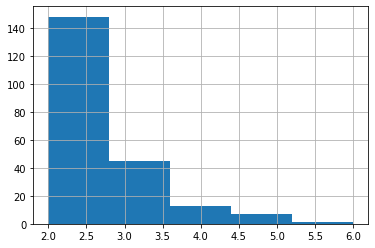

In [1793]:
courierA[courierA.batched_with_order_id > 0]['order_id'].hist(bins = 5)

In [1794]:
# рассчитатем долю мультизаказов в общем числе заказов выполняемых курьером

courierA_group = courierA.groupby('order_id').agg({'order_id': 'count'})

courierA_group.columns = ['order_id_count']

In [1795]:
courierA_group_batched_with_order_id = courierA[courierA.batched_with_order_id > 0].groupby('order_id').agg({'batched_with_order_id': 'count'})

In [1796]:
courierA_group = courierA_group.merge(courierA_group_batched_with_order_id, how='left', on = 'order_id')

In [1797]:
courierA_group = courierA_group.fillna(0)

In [1798]:
courierA_group['share_batched_with_order_id'] = courierA_group.batched_with_order_id / courierA_group.order_id_count

In [1799]:
courierA_group 

,order_id_count,batched_with_order_id,share_batched_with_order_id
order_id,,,
1,2400,0.0,0.000000
2,614,148.0,0.241042
3,156,45.0,0.288462
4,33,13.0,0.393939
5,11,7.0,0.636364
6,3,1.0,0.333333
7,1,0.0,0.000000
22,1,0.0,0.000000
28,1,0.0,0.000000


Вывод
-----

 Наличие мультипоставок зависит от количества заказов, которые выполняет курьер за сутки: Наилучший % имеют курьеры, которые поставляют 5 поставок, затем 4 заказа, затем, 6 заказов, затем 3 и 2 заказов.

# 4.Проанализируем поставки в разрезе рестаранов

In [1800]:
# сгруппируем и посмотрим сколько заказов выполняется в рамках одного ресторана в сутки

restA = dfA.groupby(['day', 'rest_id']).agg({'order_id': 'count', 'batched_with_order_id': 'count'}).reset_index()

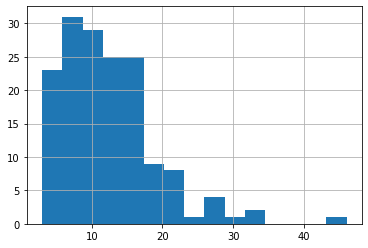

In [1801]:
restA[restA.batched_with_order_id > 0]['order_id'].hist(bins = 15)

In [1802]:
# определим долю мультзаказаов в общей доле заказов при выполнении различного объема заказов рестораном

restA_group = restA.groupby('order_id').agg({'order_id': 'count'})

restA_group.columns = ['order_id_count']

In [1803]:
restA_group_batched_with_order_id = restA[restA.batched_with_order_id > 0].groupby('order_id').agg({'batched_with_order_id': 'count'})

In [1804]:
restA_group = restA_group.merge(restA_group_batched_with_order_id, how='left', on = 'order_id')

restA_group = restA_group.fillna(0)

In [1805]:
restA_group['share_batched_with_order_id'] = restA_group.batched_with_order_id / restA_group.order_id_count

In [1806]:
restA_group

,order_id_count,batched_with_order_id,share_batched_with_order_id
order_id,,,
1,79,0.0,0.000000
2,61,0.0,0.000000
3,49,4.0,0.081633
4,70,5.0,0.071429
5,66,14.0,0.212121
6,54,3.0,0.055556
7,48,14.0,0.291667
8,38,14.0,0.368421
9,31,15.0,0.483871


Вывод
------

Чем больше число выполняемых заказов в рестаранах в сутки, тем больше доля числа заказов, выполняемых совместно

# 5. Проанализируем поставки в разрезе времени между поставками

In [1807]:
# Выделим DF, где есть мультизаказы 

dfA_multiorder = dfA[dfA['batched_with_order_id'].isna() == False]

In [1808]:
# Функция возврощает время заказа второго заказа в мультизаказе

def order_created_datetime_two_time(data):
    
    batched_with_order_id = data['batched_with_order_id']
    
    index_1 = dfA.loc[dfA.order_id == batched_with_order_id].index[0]
    
    return dfA.loc[index_1,'order_created_datetime']

In [1809]:
dfA_multiorder['order_created_datetime_two_time'] = dfA_multiorder.apply(order_created_datetime_two_time, axis = 1)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1810]:
# Определим разницу во времени между заказами в мультизаказе в минутах

dfA_multiorder['time_delta'] = (dfA_multiorder['order_created_datetime'] - dfA_multiorder['order_created_datetime_two_time']) / np.timedelta64(1, 'm')

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [1811]:
# Очистим DF от дубликатов

dfA_multiorder[dfA_multiorder.time_delta >= 0].time_delta.describe()

count    221.000000
mean       9.261916
std       34.889056
min        0.033333
25%        2.933333
50%        6.066667
75%        9.650000
max      519.800000
Name: time_delta, dtype: float64

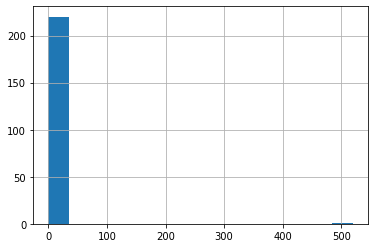

In [1812]:
dfA_multiorder[dfA_multiorder.time_delta >= 0]['time_delta'].hist(bins = 15)

Вывод
------

Как видем время между заказами медианное значение 6 минут. А вероятность того, что заказы будут выполнени совместно является то, что разница между поступленями заказов составит не более 20 минут

# 5. Проанализируем время прихода между заказами

In [1813]:
# Выделим те рестораны, где потенциально может возникнуть мультизаказ

restA_2 = restA[restA.order_id > 1]

In [1814]:
restA_2

,day,rest_id,order_id,batched_with_order_id
0,13,03e61cfb9d3325c7c88accd2b3cfa2be,16,2
1,13,0444aaef75d811aa8754f3bc77cea633,13,0
2,13,05759cc0a86c0976b8e1dbe593bd22a0,8,0
3,13,08720306483a428a1869df05b226f0db,18,2
4,13,0ab71472311f386e7a527450a2912840,18,2
...,...,...,...,...
654,16,cf6d4fc513775e1c5ef0e37fa41bd238,4,0
655,16,cfe2b53803fe67c572d68f575948671e,5,2
656,16,d1e66c75e8deec66a0aa08aefa5736aa,8,0
659,16,d96c27c8d8e2c7e386dd0cf79735df64,2,0


In [1815]:
# создадим метку ресторонов, которые выполняют только 1 заказ в сутки

dfA['tag_1_order_per_day'] = dfA['rest_id'].where(dfA['rest_id'].isin(restA_2.rest_id), '1_order')

In [1816]:
dfA.head()

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city,day,hour,tag_1_order_per_day
1,2015-09-13 18:40:12,A,9b73035bb90cd7de4b9c1ff01e44f178,NaN,793f2fa9aa3d52d2da05caa3c30cb77e,NaN,8ed37467dc9b257b3b3bdc1bfebd9b28,8,e6705560085199e9674cd721ee844d0d,13,18,9b73035bb90cd7de4b9c1ff01e44f178
2,2015-09-14 01:52:40,A,9b73035bb90cd7de4b9c1ff01e44f178,NaN,b6c5ec927a3e314b0900c103a0cd68fa,NaN,5b17547f825d9cf35c7853621dd842f8,1,e6705560085199e9674cd721ee844d0d,14,1,9b73035bb90cd7de4b9c1ff01e44f178
26,2015-09-14 15:19:47,A,19676ec4336969140631e05236712394,NaN,17755f1695806490c46e5a5c1fbf8dc7,NaN,8bda86781f9ddbfbcaa331ffa1a6a2f4,14,e6705560085199e9674cd721ee844d0d,14,15,19676ec4336969140631e05236712394
35,2015-09-14 13:01:58,A,9b73035bb90cd7de4b9c1ff01e44f178,NaN,96d9d710dd7aab07662f1fbecb96972c,NaN,3d670955da9bac56e1b70527bf0c1fd8,4,e6705560085199e9674cd721ee844d0d,14,13,9b73035bb90cd7de4b9c1ff01e44f178
42,2015-09-14 13:32:37,A,9b73035bb90cd7de4b9c1ff01e44f178,NaN,faac81c5896cb8383f5a61ad369a9f2e,NaN,a1a49d95a762bff347b70f97997c0b03,3,e6705560085199e9674cd721ee844d0d,14,13,9b73035bb90cd7de4b9c1ff01e44f178


In [1817]:
dfA_no_1 = dfA[dfA.tag_1_order_per_day != '1_order']

In [1818]:
# отсортируем рестораны и даты

dfA_no_1 = dfA_no_1.sort_values(by =['rest_id', 'order_created_datetime'])

In [1819]:
# Определим время между заказами в одном ресторане в минутах

time_delta = dfA_no_1.groupby('rest_id')['order_created_datetime'].diff()

In [1820]:
time_delta = time_delta / np.timedelta64(1, 'm')

In [1821]:
time_delta = time_delta.reset_index()

time_delta.columns = ['index', 'time_delta']

In [1822]:
time_delta

,index,time_delta
0,25046,NaN
1,25225,11.383333
2,25294,18.733333
3,25007,3.750000
4,24839,18.533333
...,...,...
4866,30943,120.400000
4867,30878,78.166667
4868,30957,1215.516667
4869,31766,262.183333


In [1823]:
dfA_no_1 = dfA_no_1.reset_index()

In [1824]:
dfA_no_1 = dfA_no_1.merge(time_delta, how = 'left', on = 'index')

In [1825]:
dfA_no_1.head()

,index,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city,day,hour,tag_1_order_per_day,time_delta
0,25046,2015-09-13 11:24:24,A,03e61cfb9d3325c7c88accd2b3cfa2be,NaN,96abdf37ff71f3ab4cbb1cfcb43a9a3d,NaN,2af733d3c98db5226871a158d36d999d,1,e6705560085199e9674cd721ee844d0d,13,11,03e61cfb9d3325c7c88accd2b3cfa2be,NaN
1,25225,2015-09-13 11:35:47,A,03e61cfb9d3325c7c88accd2b3cfa2be,NaN,399ceb9a041df0a338ecdfcccd4309f4,NaN,2c836ec50a9e78259de02aff97fa0da9,6,e6705560085199e9674cd721ee844d0d,13,11,03e61cfb9d3325c7c88accd2b3cfa2be,11.383333
2,25294,2015-09-13 11:54:31,A,03e61cfb9d3325c7c88accd2b3cfa2be,e0c4053a9330db0c071077c417a186fc,87b092f55dca7eafdcfff64c80b22c89,1.0,4e3243405d91b074e142849272d56ea8,6,e6705560085199e9674cd721ee844d0d,13,11,03e61cfb9d3325c7c88accd2b3cfa2be,18.733333
3,25007,2015-09-13 11:58:16,A,03e61cfb9d3325c7c88accd2b3cfa2be,87b092f55dca7eafdcfff64c80b22c89,e0c4053a9330db0c071077c417a186fc,0.0,4e3243405d91b074e142849272d56ea8,4,e6705560085199e9674cd721ee844d0d,13,11,03e61cfb9d3325c7c88accd2b3cfa2be,3.750000
4,24839,2015-09-13 12:16:48,A,03e61cfb9d3325c7c88accd2b3cfa2be,NaN,2e34f208af9e41fd66cbf7b9d91c253a,NaN,2c836ec50a9e78259de02aff97fa0da9,5,e6705560085199e9674cd721ee844d0d,13,12,03e61cfb9d3325c7c88accd2b3cfa2be,18.533333


In [1826]:
#dfA_no_1['time_delta'] = dfA_no_1['time_delta'].astype(float)
dfA_no_1['time_delta'] = dfA_no_1['time_delta'].fillna(0)

In [1827]:
dfA_no_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4871 entries, 0 to 4870
Data columns (total 14 columns):
index                      4871 non-null int64
order_created_datetime     4871 non-null datetime64[ns]
brand_name                 4871 non-null object
rest_id                    4871 non-null object
batched_with_order_id      442 non-null object
order_id                   4871 non-null object
first_in_multiorder_flg    442 non-null float64
courier_id                 4851 non-null object
order_items_cnt            4871 non-null int64
city                       4871 non-null object
day                        4871 non-null int64
hour                       4871 non-null int64
tag_1_order_per_day        4871 non-null object
time_delta                 4871 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(7)
memory usage: 570.8+ KB


In [1828]:
# построим график рассеивания времени между заказами и количеством заказов для мультизаказов и для их отсуствия

delta_timeA = dfA_no_1[dfA_no_1['batched_with_order_id'].isna() == False].groupby(['rest_id']).agg({'order_id': 'count', 'batched_with_order_id': 'count', 'time_delta': 'mean'}).reset_index()

In [1829]:
delta_timeA.head()

,rest_id,order_id,batched_with_order_id,time_delta
0,03e61cfb9d3325c7c88accd2b3cfa2be,8,8,30.956250
1,05759cc0a86c0976b8e1dbe593bd22a0,2,2,50.008333
2,08720306483a428a1869df05b226f0db,4,4,112.991667
3,0ab71472311f386e7a527450a2912840,4,4,15.458333
4,123d69fd98bedf3de42693cb48e89333,4,4,18.520833


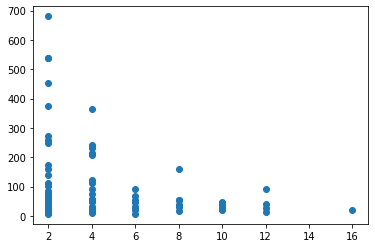

In [1830]:
plt.scatter(delta_timeA.order_id, delta_timeA.time_delta)

In [1831]:
delta_timeA = dfA_no_1[dfA_no_1['batched_with_order_id'].isna() == True].groupby(['rest_id']).agg({'order_id': 'count', 'batched_with_order_id': 'count', 'time_delta': 'mean'}).reset_index()

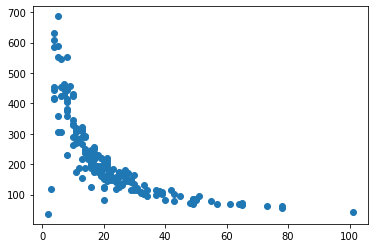

In [1832]:
plt.scatter(delta_timeA.order_id, delta_timeA.time_delta)

Вывод
------
 
 Видно, что количество времени между заказами оказывает воздействие на то, что будет мультизаказ или нет. 

# 6.Проверим как распределяются с количеством блюд в одном заказе

In [1833]:
# сгрупируем как влияет взаимосвязаны количество блюд в заказе, на количество таких заказов и количество мультизаказов

order_items_cntA = dfA.groupby(['rest_id', 'order_items_cnt']).agg({'order_id': 'count', 'batched_with_order_id': 'count'})

order_items_cntA['share'] = order_items_cntA['batched_with_order_id'] / order_items_cntA['order_id']

In [1834]:
order_items_cntA = order_items_cntA.reset_index()

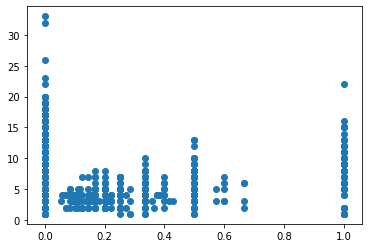

In [1835]:
plt.scatter(order_items_cntA.share, order_items_cntA.order_items_cnt)

Вывод
------

Количество блюд в заказе существенно не влияют на количество выполняемых мультизаказов

# Вывод по разделу:

В ходе анализа было выявлено, что на наличие или отсуствие мультизаказа влияют:
   - количество заказов в сутки, которые приходят в ресторан;
   - количество заказов которые выполняет 1 курьер;
   - количество времени в минутах между заказами;

# Подготовим и обучим модель

В качестве характеристик модели будут:
    - Среднее дневное количество заказов, выполняемых курьером
    - Среднее дневное количество закзаов, выполняемых в ресторане
    - Время между заказами в рамках одного ресторана.

В качестве целевой функции будем использовать относится ли данный заказ к мультизакзау или нет

В качестве модели будем использовать логистическую регрессию

In [1836]:
# сортируем данные для торговой марки А в разрезе рестаранов и даты

dfA = dfA.sort_values(by=['rest_id', 'order_created_datetime'])

In [1837]:
# заполняем пропуски по курьерам

dfA['courier_id'] = dfA['courier_id'].fillna(dfA['courier_id'].value_counts().index[0])

In [1838]:
# определяем время между заказами в разрезе рестаранов в минутах

deltatime = dfA.groupby('rest_id')['order_created_datetime'].diff().reset_index()

deltatime.columns = ['index', 'deltatime']

deltatime['deltatime'] = deltatime['deltatime'] / np.timedelta64(1, 'm')


In [1839]:
dfA = dfA.reset_index()

In [1840]:
dfA = dfA.merge(deltatime, how = 'left', on='index')

In [1841]:
dfA['deltatime'] = dfA['deltatime'].fillna(0)

In [1842]:
# создаем словарь для определния среднедневного количества заказов для ресторанов

dict_rest = dfA.groupby(['rest_id', 'day']).agg({'order_id': 'count'}).reset_index()

dict_rest = dict_rest.groupby('rest_id').agg({'order_id': 'median'})

In [1843]:
# создаем словарь для определения количества выполненных заказов курьерами

dict_courier = dfA.groupby(['courier_id', 'day']).agg({'order_id': 'count'}).reset_index()

dict_courier = dict_courier.groupby('courier_id').agg({'order_id': 'median'})

In [1844]:
# создаем новые признаки для прогноза

dfA['count_rest_order'] = dfA.apply(lambda row: dict_rest.loc[row['rest_id']]['order_id'], axis = 1)

dfA['count_courier_order'] = dfA.apply(lambda row: dict_courier.loc[row['courier_id']]['order_id'], axis = 1)

In [1845]:
# создаем прогнозируемый признак

dfA['target'] = dfA['batched_with_order_id'].isna()

dfA['target'] = dfA['target'].apply(lambda x: 1 if x == False else 0)

In [1846]:
X = dfA[['deltatime', 'count_rest_order', 'count_courier_order']]

y = dfA['target']

In [1847]:
# на базе логистической регрессии создаем модель и обучаем ее

model = LogisticRegression(random_state=12345)

model.fit(X, y)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

# Подготовим данные для прогноза на основе данных ресторана B и составим прогноз

In [1848]:
# Выделяем DF с ресторанами бренда B

dfB = df[df.brand_name == 'B']

In [1849]:
# Сортируем данные в разрезе город, ресторан, даты заказов

dfB = dfB.sort_values(by=['city', 'rest_id', 'order_created_datetime'])

In [1850]:
# заполняем пропуски 0

dfB.batched_with_order_id = dfB.batched_with_order_id.fillna(0)

dfB.first_in_multiorder_flg = dfB.first_in_multiorder_flg.fillna(0)

In [1851]:
# удаляем пропуски курьеров

dfB = dfB.dropna()

In [1852]:
# определяем время между заказами в разрезе города, ресторана в минутах

deltatime = dfB.groupby(['city', 'rest_id'])['order_created_datetime'].diff().reset_index()

deltatime.columns = ['index', 'deltatime']

deltatime['deltatime'] = deltatime['deltatime'] / np.timedelta64(1, 'm')

In [1853]:
dfB = dfB.reset_index()

In [1854]:
dfB = dfB.merge(deltatime, how = 'left', on='index')

In [1855]:
dfB['deltatime'] = dfB['deltatime'].fillna(0)

In [1856]:
# Создаем словарь количества заказов в разрезе города, ресторана в день

dict_rest = dfB.groupby(['city', 'rest_id','day']).agg({'order_id': 'count'}).reset_index()

dict_rest = dict_rest.groupby('rest_id').agg({'order_id': 'median'})

In [1857]:
# создаем словарь для определения среднего количества выполненых заказов курьером в день

dict_courier = dfB.groupby(['city', 'courier_id', 'day']).agg({'order_id': 'count'}).reset_index()

dict_courier = dict_courier.groupby('courier_id').agg({'order_id': 'median'})

In [1858]:
# создаем новые признаки 

dfB['count_rest_order'] = dfB.apply(lambda row: dict_rest.loc[row['rest_id']]['order_id'], axis = 1)

dfB['count_courier_order'] = dfB.apply(lambda row: dict_courier.loc[row['courier_id']]['order_id'], axis = 1)

In [1859]:
X_valid = dfB[['deltatime', 'count_rest_order', 'count_courier_order']]

In [1860]:
# составляем прогноз

predict = model.predict(X_valid)

In [1861]:
# определяем коэффициенты для модели

model.coef_

array([[-0.00256357,  0.01935715, -0.03857581]])

In [1862]:
# определяем долю мультизаказов

round (100 * (predict.sum() / len(predict)), 2)

6.63

Вывод
------

  Таким образом для ресторанов бренда B получился результат __6.63%__ заказов относится к мультизаказам

In [1863]:
df.head()

,order_created_datetime,brand_name,rest_id,batched_with_order_id,order_id,first_in_multiorder_flg,courier_id,order_items_cnt,city,day,hour
0,2015-09-15 21:08:43,B,7cc98331ddb8ccffe464455f3df763d9,NaN,0b6f25c79b35fd1e6d28d845b7ee511d,NaN,3f1b96f620988a92d3409ea05e87bd36,3,c6fbacc5cab7e134c9db2a4bbfcc5b64,15,21
1,2015-09-13 18:40:12,A,9b73035bb90cd7de4b9c1ff01e44f178,NaN,793f2fa9aa3d52d2da05caa3c30cb77e,NaN,8ed37467dc9b257b3b3bdc1bfebd9b28,8,e6705560085199e9674cd721ee844d0d,13,18
2,2015-09-14 01:52:40,A,9b73035bb90cd7de4b9c1ff01e44f178,NaN,b6c5ec927a3e314b0900c103a0cd68fa,NaN,5b17547f825d9cf35c7853621dd842f8,1,e6705560085199e9674cd721ee844d0d,14,1
3,2015-09-13 17:23:52,B,7cc98331ddb8ccffe464455f3df763d9,NaN,5dc658f0928569dbefac74c9f311031c,NaN,81647a72700bd46635d9606082360cc8,6,c6fbacc5cab7e134c9db2a4bbfcc5b64,13,17
4,2015-09-13 11:15:05,B,7cc98331ddb8ccffe464455f3df763d9,NaN,3da09410aeab781baf4b7039fc9b125c,NaN,065c18216b6d3369d4cc36418c6e80f2,7,c6fbacc5cab7e134c9db2a4bbfcc5b64,13,11


In [1870]:
df.groupby(['courier_id', 'day']).agg({'order_id': 'count'})['order_id'].describe()

count    18073.000000
mean         3.663033
std          5.246122
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max        282.000000
Name: order_id, dtype: float64